# Th analysis

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.xy_algorithms as xy
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database import load_db
from   invisible_cities.core.configure         import configure
from   invisible_cities.core.exceptions import SipmEmptyList
from   invisible_cities.core.exceptions import SipmZeroCharge

from   invisible_cities.io.pmap_io             import load_pmaps
from   invisible_cities.reco                   import pmaps_functions  as pmp
from   invisible_cities.evm.event_model        import Hit, Cluster
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.filters.s1s2_filter    import s1s2_filter
from   invisible_cities.filters.s1s2_filter    import s2si_filter
from   invisible_cities.filters.s1s2_filter    import S12Selector

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [2]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values
#print(DataSiPM)
#print(data_xs)
#print(data_ys)

# histograms to be filled
l_qsipm = []            # all SiPMs
l_qsipm_cluster = []    # all SiPMs within any cluster

l_qsipm_ccenter = []    # the cluster center charges
l_qsipm_qcluster = []   # the cluster energies (same number of entries as l_qsipm_ccenter)

nccenters = 6
l_qsipm_iccenter = []
for n in range(nccenters): l_qsipm_iccenter.append([])

rqmin = 0; rqmax = 70        # charge minima and maxima for charge vs. radius plots
l_q_rlm = []; l_r_rlm = []   # for SiPM charge vs. r within lm_radius
l_q_rnlm = []; l_r_rnlm = [] # for SiPM charge vs. r within new_lm_radius

def barycenter(pos, qs):
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]

def corona(pos, qs, Qthr           =  3 * units.pes,
                    Qlm            =  15 * units.pes,
                        lm_radius  = 15.0 * units.mm,
                    new_lm_radius  = 15.0 * units.mm,
                    msipm          =  6):
    """
    corona creates a list of Clusters by
    first , identifying a loc max (gonz wanted more precise than just max sipm)
    second, calling barycenter to find the Cluster given by SiPMs around the max
    third , removing (nondestructively) the sipms contributing to that Cluster
    until there are no more local maxima
    kwargs
    Qthr : SiPMs with less than Qthr pes are ignored
    Qlm  : local maxima must have a SiPM with at least T pes
    lm_radius  : all SiPMs within lm_radius distance from the local max
           SiPM are used (by barycenter) to compute the approximate center
            of the local max.
    new_lm_radius : xs,ys,qs, of SiPMs within new_lm_radius of a local max
           are used by barycenter to compute a Cluster.
    msipm: the minimum number of SiPMs needed to make a cluster
    returns
    c    : a list of Clusters
    """
    c  = []
    # Keep SiPMs with at least Qthr pes
    above_threshold = np.where(qs >= Qthr)[0]
    pos, qs = pos[above_threshold], qs[above_threshold]
    
    
    # While there are more local maxima
    ncenter = 0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

        # find locmax (the baryc of charge in SiPMs less than lm_radius from hottest_sipm)
        within_lm_radius = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius],
                                        qs [within_lm_radius])[0].posxy[0]

        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - pos[hottest_sipm], axis=0)
            if(d < lm_radius and q > rqmin and q < rqmax):
                l_q_rlm.append(q)
                l_r_rlm.append(d)

        # new_lm_radius is an array of the responsive sipms less than
        # new_lm_radius from locmax
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum,
                                                    new_lm_radius, pos, qs)
        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - new_local_maximum, axis=0)
            #print("Types are d {0}, q {1}, new_lm_radius {2}, rqmin {3}, rqmax {4}".format(type(d),type(q),type(new_lm_radius),type(rqmin),type(rqmax)))
            if(d < new_lm_radius and q > rqmin and q < rqmax):
                l_q_rnlm.append(q)
                l_r_rnlm.append(d)

        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            c.extend(barycenter(pos[within_new_lm_radius],
                                qs [within_new_lm_radius]))
            for q in qs[within_new_lm_radius]: l_qsipm_cluster.append(q)
            l_qsipm_ccenter.append(qs[hottest_sipm])
            l_qsipm_qcluster.append(sum(qs))
            if(ncenter < nccenters): l_qsipm_iccenter[ncenter].append(qs[hottest_sipm])
            ncenter += 1

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    Qs = np.array(Qs)
    #xs, ys  = data_xs[IDs], data_ys[IDs]
    for q in Qs: l_qsipm.append(q)
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs],data_ys[IDs])])
    return corona(pos, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the corrections table

7.92
Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


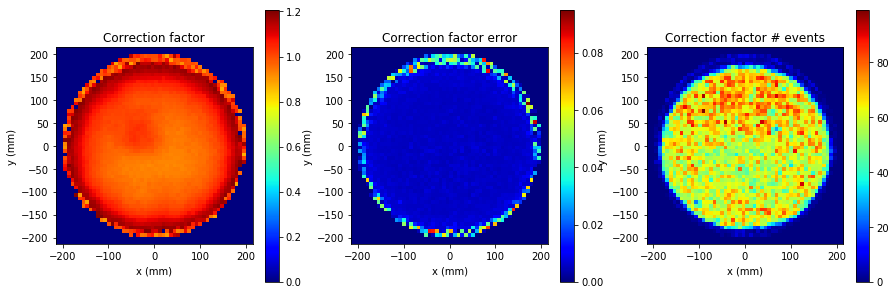

In [3]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b10.corr"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/old/mcKr.corr"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
fcorr = tb.open_file(corr_file,'r')

ncbins = 54

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor (MC)
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)
print(xbin)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))
    
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Perform initial analysis with a DST

In [4]:
# code from Gonzalo
run_number    = 4484
inputfilename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4484/dst/dst_{}.root.h5".format(run_number)
full = dstf.load_dst(inputfilename, "DST", "Events")
print(len(full))
full.head()

9504


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.499970e+09,0,1,275.0,59.174740,353.042031,847550.0,55.457375,18207.923828,...,1029962.5,476,182.4125,182.4125,-58.229906,81.104390,99.843097,2.193476,45.702965,47.963936
1,3,1.499970e+09,0,1,325.0,76.771904,457.793548,732400.0,56.277750,18307.046875,...,1017012.5,452,284.6125,284.6125,15.476704,140.621437,141.470551,1.461178,50.471513,49.563160
2,5,1.499970e+09,0,1,300.0,85.588783,468.010359,865650.0,79.354250,18597.736328,...,1034887.5,597,169.2375,169.2375,-129.406866,-40.362241,135.555330,-2.839253,59.320594,49.241932
3,6,1.499970e+09,0,1,300.0,124.138268,708.545367,648700.0,73.337500,17789.914062,...,1030162.5,613,381.4625,381.4625,-77.007666,-104.085437,129.475707,-2.207770,50.810358,71.496101
4,7,1.499970e+09,0,2,275.0,77.786621,427.330454,988525.0,117.973250,17468.431641,...,1006412.5,363,17.8875,17.8875,114.734600,-118.843244,165.190027,-0.802986,42.140763,43.704905


Number of events used in histograms = 7779


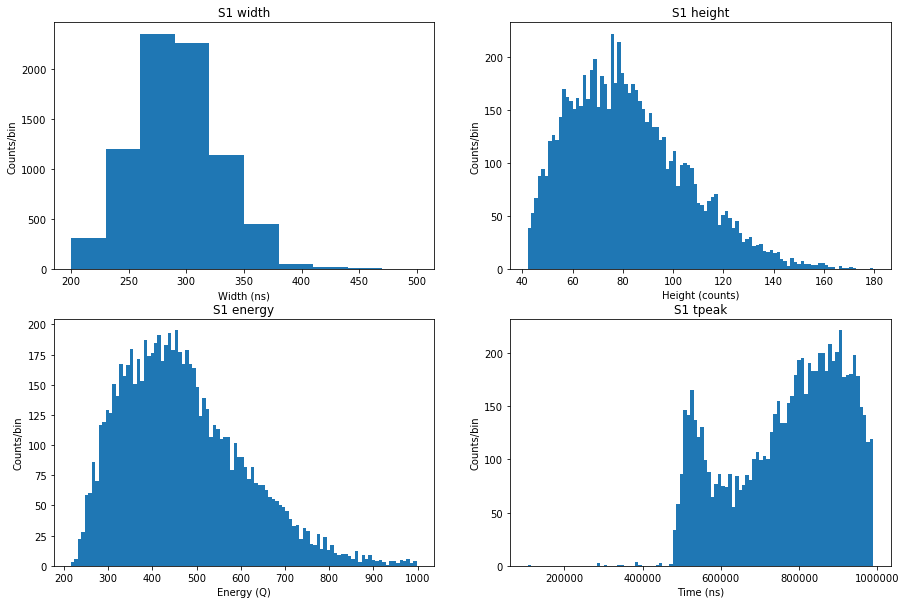

In [5]:
# histograms of quantities of interest (S1)
print("Number of events used in histograms = {0}".format(len(full[full.peak == 0])))
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(full.S1w[full.peak == 0],bins=10)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S1 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(full.S1h[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 height')
plt.xlabel('Height (counts)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(full.S1e[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 energy')
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(full.S1t[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

Number of events used in histograms = 9504


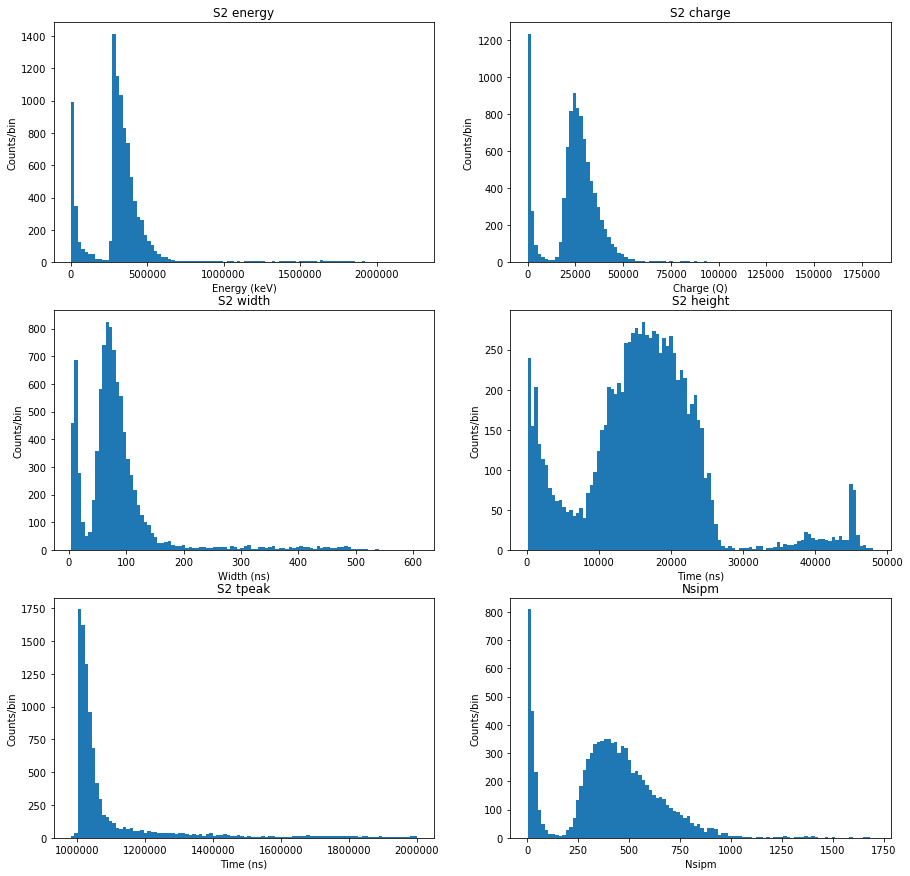

In [7]:
# histograms of quantities of interest (S2)
print("Number of events used in histograms = {0}".format(len(full)))
fig = plt.figure(1)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(321);
plt.hist(full.S2e,bins=100)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S2 energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(322)
plt.hist(full.S2q,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 charge')
plt.xlabel('Charge (Q)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(323)
plt.hist(full.S2w,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(324)
plt.hist(full.S2h,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 height')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax5 = fig.add_subplot(325)
plt.hist(full.S2t,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax6 = fig.add_subplot(326)
plt.hist(full.Nsipm,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('Nsipm')
plt.xlabel('Nsipm')
plt.ylabel('Counts/bin')

In [ ]:
# show energy spectrum directly from DST


## Read the PMaps and construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [8]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(20.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [30]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000
tlife = 1050
cfile = '/Users/jrenner/IFIC/IC-1/invisible_cities/config/s12_selector_4491.conf'

# read the configuration file
conf = configure(['bar', cfile])
_s1s2_selector = S12Selector(**conf.as_dict)

In [32]:
hitc_evt = []; hitc_mc = []; ext1_mc = []; ext2_mc = []
evtnum_hitc = []
#nfiles = 107
print_cut = True
tbl_ri = 0
tot_evts_sum = 0
l_rnums = [4484, 4489, 4491] # [1000]
l_nfiles = [122, 95, 107] # [1]

for rnum,nfiles in zip(l_rnums,l_nfiles):
    
    print("\n--- RUN {0} ---".format(rnum))
    for ifile in range(nfiles):

        print("File {0} of {1}...".format(ifile,nfiles))

        if(ifile < 10): fstr = "00{0}".format(ifile)
        elif(ifile < 100): fstr = "0{0}".format(ifile)
        else: fstr = "{0}".format(ifile)

        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{0}_0_7bar_pmaps_10000.root.h5".format(ifile)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/{0}/pmaps/pair_1592keV_z250mm_10evt_pmaps.root.h5".format(rnum)
        filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/pmaps/pmaps.gdcsnext.{1}_{2}.root.h5".format(rnum,fstr,rnum)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.{0}_3913.root.h5".format(fstr)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3755/pmaps/pmaps.gdcsnext.{0}_3755.root.h5".format(fstr)
        if(not os.path.isfile(filename)):
            print("File {0} does not exist. Skipping.".format(ifile))
            continue
        try:
            S1s, S2s, S2Sis = load_pmaps(filename)
        except (ValueError, tb.exceptions.NoSuchNodeError):
            print("Empty file {0}. Skipping.".format(ifile))
        event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(filename)
        ftbl = tb.open_file(filename,'r')

        tot_evts_sum += len(event_numbers)
        print("... {0} events in file ({1} total)".format(len(event_numbers), tot_evts_sum))
        for evt_number, evt_time in zip(event_numbers,timestamps):
            #print("Processing event {0}".format(evt_number))
            hitc = []

            s1   = S1s  .get(evt_number, {})
            s2   = S2s  .get(evt_number, {})
            s2si = S2Sis.get(evt_number, {})

            if(not s1 or not s2 or not s2si):
                if(print_cut):
                    print("Skipping event {0}:".format(evt_number))
                    if(not s1): print("-- empty s1")
                    if(not s2): print("-- empty s2")
                    if(not s2si): print("-- empty s2si")
                continue
            if(len(s2.s2d) != len(s2si.s2sid)): 
                if(print_cut): print("Skipping event {0}: length of s2 does not match that of s2si".format(evt_number))
                continue
            #print(type(s2si))
            #print(s2.s2d.keys())
            #print(s2si.s2sid.keys())

            f1 = s1s2_filter(_s1s2_selector, s1, s2, s2si)
            f2 = s2si_filter(s2si)
            if not f1 or not f2:
                continue

            esum = sum([sum(earr) for pnum,(tarr,earr) in sorted(s2.s2d.items())])

            if(not (tot_Emin <= esum <= tot_Emax)):
                if(print_cut): print("Skipping event {0}: did not make energy cuts...".format(evt_number))
            else:
                t, e = next(iter(s1.s1d.values()))
                S1t  = t[np.argmax(e)]
                s2, s2si = pmp.rebin_s2si(s2,s2si,2)
                #S2, Si = rebin_s2(S2, Si)

                npeak = 0
                for peak_no, (t_peak, e_peak) in sorted(s2.s2d.items()):
                    si = s2si.s2sid[peak_no]
                    e_left = 0
                    for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                        #print("Slice number {0}".format(slice_no))
                        incomplete = False
                        for sipm_no,sipm in si.items():
                            if(slice_no >= len(sipm)):
                                incomplete = True
                        if(incomplete):
                            print("WARNING: incomplete charge information for slice ")
                            e_left += e_slice
                        else:
                            clusters = compute_xy_position(si, slice_no)
                            #print("Computed pos")
                            if(len(clusters) == 0):
                                e_left += e_slice
                            else:
                                es       = split_energy(e_slice + e_left, clusters)
                                z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
                                for c, e in zip(clusters, es):
                                    hit       = Hit(peak_no,c,z,e)
                                    #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                                    #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                                    hitc.append(hit)
                                e_left = 0
                    if(len(hitc) > 0 and e_left > 0):
                        hitc[-1].energy += e_left
                    npeak += 1

                hitc_evt.append(hitc)
                evtnum_hitc.append(evt_number)

                # record MC information if available
                if(ftbl.__contains__('/MC')):
                    hitcm = []
                    mctbl = ftbl.root.MC.MCTracks
                    mcevt = 0; eemax = 0
                    ext1 = np.zeros(3); ext2 = np.zeros(3)
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] != evt_number):
                    #while(tbl_ri < len(mctbl) and (tbl_ri != 0 and mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                    #    tbl_ri += 1
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['mctrk_indx'] == evt_number):
                    while(tbl_ri < len(mctbl) and (tbl_ri == 0 or mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                        hpos = mctbl[tbl_ri]['hit_position']
                        henergy = mctbl[tbl_ri]['hit_energy']
                        hit = Hit(0,Cluster(0, xy(hpos[0],hpos[1]), xy(0,0), 0),hpos[2],henergy)
                        hitcm.append(hit)
                        if(mctbl[tbl_ri]['particle_name'] == 'e+'):
                            ext1[0] = hpos[0]; ext1[1] = hpos[1]; ext1[2] = hpos[2]
                        elif(mctbl[tbl_ri]['particle_name'] == 'e-' and mctbl[tbl_ri]['energy'] > eemax):
                            ext2[0] = hpos[0]; ext2[1] = hpos[1]; ext2[2] = hpos[2]
                        print("MCTrack index = {0}".format(mctbl[tbl_ri]['mctrk_indx']))
                        tbl_ri += 1
                    hitc_mc.append(hitcm)
                    ext1_mc.append(ext1)
                    ext2_mc.append(ext2)
                    mcevt += 1
                    tbl_ri += 1

        ftbl.close()
    print("Produced hit collections for {0} events ({1} events in MC truth).".format(len(hitc_evt),len(hitc_mc)))


--- RUN 4484 ---
File 0 of 122...
... 112 events in file (112 total)
Skipping event 1:
-- empty s2
-- empty s2si
Skipping event 4:
-- empty s2
-- empty s2si
Skipping event 9:
-- empty s1
Skipping event 10:
-- empty s2
-- empty s2si
Skipping event 12: length of s2 does not match that of s2si
Skipping event 13: length of s2 does not match that of s2si
Skipping event 19:
-- empty s1
Skipping event 20: did not make energy cuts...
Skipping event 31:
-- empty s1
Skipping event 32:
-- empty s2
-- empty s2si
Skipping event 38:
-- empty s2
-- empty s2si
Skipping event 43:
-- empty s2
-- empty s2si
Skipping event 54: length of s2 does not match that of s2si
Skipping event 56:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 70:
-- empty s2
-- empty s2si
Skipping event 78:
-- empty s2
-- empty s2si
Skipping event 86:
-- empty s2
-- empty s2si
Skipping event 93: length of s2 does not match that of s2si
Skipping event 96: length of s2 does not match that of s2si
Skipping event 97: length of s2

Skipping event 954:
-- empty s2
-- empty s2si
Skipping event 957:
-- empty s2si
Skipping event 976:
-- empty s2
-- empty s2si
Skipping event 977: length of s2 does not match that of s2si
Skipping event 986:
-- empty s1
Skipping event 997:
-- empty s2
-- empty s2si
Skipping event 1001: length of s2 does not match that of s2si
Skipping event 1003:
-- empty s2
-- empty s2si
Skipping event 1004: length of s2 does not match that of s2si
File 9 of 122...
... 112 events in file (979 total)
Skipping event 1022:
-- empty s2
-- empty s2si
Skipping event 1025:
-- empty s1
Skipping event 1026:
-- empty s2
-- empty s2si
Skipping event 1033: length of s2 does not match that of s2si
Skipping event 1037:
-- empty s2
-- empty s2si
Skipping event 1044:
-- empty s1
Skipping event 1045:
-- empty s2
-- empty s2si
Skipping event 1047:
-- empty s1
Skipping event 1049:
-- empty s2
-- empty s2si
Skipping event 1057:
-- empty s2
-- empty s2si
Skipping event 1058:
-- empty s1
-- empty s2
-- empty s2si
Skipping e

Skipping event 1999: length of s2 does not match that of s2si
Skipping event 2000:
-- empty s2
-- empty s2si
Skipping event 2012: length of s2 does not match that of s2si
Skipping event 2013:
-- empty s2
-- empty s2si
Skipping event 2015: length of s2 does not match that of s2si
File 18 of 122...
... 112 events in file (1788 total)
Skipping event 2025:
-- empty s2
-- empty s2si
Skipping event 2028:
-- empty s2
-- empty s2si
Skipping event 2029:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2032: length of s2 does not match that of s2si
Skipping event 2044: length of s2 does not match that of s2si
Skipping event 2045:
-- empty s2
-- empty s2si
Skipping event 2055:
-- empty s2
-- empty s2si
Skipping event 2056: length of s2 does not match that of s2si
Skipping event 2057: length of s2 does not match that of s2si
Skipping event 2062: length of s2 does not match that of s2si
Skipping event 2065:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2066:
-- empty s1
Skipping event 20

Skipping event 2837: length of s2 does not match that of s2si
Skipping event 2840:
-- empty s1
Skipping event 2846:
-- empty s2
-- empty s2si
Skipping event 2850:
-- empty s2
-- empty s2si
Skipping event 2854:
-- empty s2
-- empty s2si
Skipping event 2856:
-- empty s1
Skipping event 2862:
-- empty s2
-- empty s2si
Skipping event 2863: length of s2 does not match that of s2si
Skipping event 2867: length of s2 does not match that of s2si
Skipping event 2868:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2869:
-- empty s2
-- empty s2si
Skipping event 2873:
-- empty s2
-- empty s2si
Skipping event 2892:
-- empty s2
-- empty s2si
Skipping event 2894:
-- empty s2
-- empty s2si
Skipping event 2898:
-- empty s2
-- empty s2si
Skipping event 2901:
-- empty s2
-- empty s2si
Skipping event 2909:
-- empty s2
-- empty s2si
File 26 of 122...
... 112 events in file (2457 total)
Skipping event 2914:
-- empty s2
-- empty s2si
Skipping event 2919:
-- empty s2
-- empty s2si
Skipping event 2928:
-- 

Skipping event 3823: length of s2 does not match that of s2si
Skipping event 3829:
-- empty s2
-- empty s2si
Skipping event 3833:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3836:
-- empty s1
Skipping event 3846:
-- empty s2si
Skipping event 3848:
-- empty s2si
Skipping event 3850:
-- empty s2
-- empty s2si
Skipping event 3854:
-- empty s2
-- empty s2si
Skipping event 3856:
-- empty s2si
Skipping event 3860:
-- empty s2
-- empty s2si
Skipping event 3861:
-- empty s2
-- empty s2si
Skipping event 3864:
-- empty s2
-- empty s2si
Skipping event 3865:
-- empty s2
-- empty s2si
Skipping event 3877:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3880:
-- empty s1
Skipping event 3888:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3892: length of s2 does not match that of s2si
Skipping event 3908:
-- empty s1
Skipping event 3913:
-- empty s2
-- empty s2si
Skipping event 3915: length of s2 does not match that of s2si
Skipping event 3918:
-- empty s2
-- empty s2si
File 35 of

Skipping event 4776:
-- empty s2
-- empty s2si
Skipping event 4788:
-- empty s2
-- empty s2si
Skipping event 4789:
-- empty s1
Skipping event 4791:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4801:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4806: length of s2 does not match that of s2si
Skipping event 4810: length of s2 does not match that of s2si
File 43 of 122...
... 112 events in file (3872 total)
Skipping event 4817:
-- empty s2
-- empty s2si
Skipping event 4820:
-- empty s2si
Skipping event 4821:
-- empty s1
Skipping event 4825:
-- empty s2
-- empty s2si
Skipping event 4834:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4841: length of s2 does not match that of s2si
Skipping event 4844:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4847:
-- empty s2
-- empty s2si
Skipping event 4850: length of s2 does not match that of s2si
Skipping event 4854:
-- empty s2
-- empty s2si
Skipping event 4867:
-- empty s1
Skipping event 4869:
-- empty s1
Skipping even

Skipping event 5660:
-- empty s2
-- empty s2si
Skipping event 5675:
-- empty s2
-- empty s2si
Skipping event 5680:
-- empty s2
-- empty s2si
Skipping event 5683: length of s2 does not match that of s2si
Skipping event 5685: length of s2 does not match that of s2si
Skipping event 5686:
-- empty s2
-- empty s2si
Skipping event 5692:
-- empty s2
-- empty s2si
Skipping event 5702: length of s2 does not match that of s2si
Skipping event 5705:
-- empty s2
-- empty s2si
Skipping event 5708: length of s2 does not match that of s2si
File 51 of 122...
... 12 events in file (4490 total)
Skipping event 5714: length of s2 does not match that of s2si
Skipping event 5719:
-- empty s2
-- empty s2si
File 52 of 122...
... 112 events in file (4602 total)
Skipping event 5825: length of s2 does not match that of s2si
Skipping event 5827:
-- empty s2si
Skipping event 5829:
-- empty s2si
Skipping event 5831:
-- empty s2
-- empty s2si
Skipping event 5833:
-- empty s2
-- empty s2si
Skipping event 5837: length 

Skipping event 6831:
-- empty s2
-- empty s2si
File 61 of 122...
... 59 events in file (5269 total)
Skipping event 6833:
-- empty s2
-- empty s2si
Skipping event 6836:
-- empty s1
Skipping event 6841:
-- empty s2
-- empty s2si
Skipping event 6842:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6843:
-- empty s2si
Skipping event 6845: length of s2 does not match that of s2si
Skipping event 6849:
-- empty s2
-- empty s2si
Skipping event 6852:
-- empty s2si
Skipping event 6856:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6857: length of s2 does not match that of s2si
Skipping event 6858:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6859:
-- empty s2si
Skipping event 6874:
-- empty s2
-- empty s2si
Skipping event 6875:
-- empty s1
Skipping event 6879:
-- empty s2
-- empty s2si
Skipping event 6883: length of s2 does not match that of s2si
Skipping event 6891:
-- empty s2
-- empty s2si
File 62 of 122...
... 111 events in file (5380 total)
Skipping event 6948:
-- empty 

Skipping event 7615:
-- empty s2
-- empty s2si
File 68 of 122...
... 111 events in file (5975 total)
Skipping event 7617:
-- empty s2
-- empty s2si
Skipping event 7618:
-- empty s1
Skipping event 7622:
-- empty s2
-- empty s2si
Skipping event 7629:
-- empty s2
-- empty s2si
Skipping event 7634:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7641: length of s2 does not match that of s2si
Skipping event 7652:
-- empty s2si
Skipping event 7659:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7663:
-- empty s2si
Skipping event 7667:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7669:
-- empty s2
-- empty s2si
Skipping event 7676:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7679:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7681:
-- empty s2
-- empty s2si
Skipping event 7686:
-- empty s2
-- empty s2si
Skipping event 7693:
-- empty s2si
Skipping event 7698: length of s2 does not match that of s2si
Skipping event 7702: length of s2 does not match that of s2s

Skipping event 8531:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 8535:
-- empty s2
-- empty s2si
Skipping event 8541:
-- empty s2
-- empty s2si
Skipping event 8551: length of s2 does not match that of s2si
Skipping event 8554: length of s2 does not match that of s2si
Skipping event 8557:
-- empty s2
-- empty s2si
Skipping event 8565: length of s2 does not match that of s2si
Skipping event 8566: length of s2 does not match that of s2si
Skipping event 8570:
-- empty s2
-- empty s2si
Skipping event 8572:
-- empty s2
-- empty s2si
Skipping event 8574: length of s2 does not match that of s2si
Skipping event 8575:
-- empty s1
Skipping event 8579:
-- empty s2
-- empty s2si
Skipping event 8581:
-- empty s2si
File 77 of 122...
... 112 events in file (6788 total)
Skipping event 8629:
-- empty s2
-- empty s2si
Skipping event 8633: length of s2 does not match that of s2si
Skipping event 8636:
-- empty s2
-- empty s2si
Skipping event 8649:
-- empty s1
-- empty s2
-- empty s2si
Skipping eve

Skipping event 9486:
-- empty s2
-- empty s2si
Skipping event 9487: length of s2 does not match that of s2si
Skipping event 9489:
-- empty s2
-- empty s2si
Skipping event 9495:
-- empty s2
-- empty s2si
Skipping event 9502:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9511:
-- empty s2
-- empty s2si
Skipping event 9512:
-- empty s2
-- empty s2si
Skipping event 9513:
-- empty s2
-- empty s2si
Skipping event 9516:
-- empty s1
File 85 of 122...
... 112 events in file (7594 total)
Skipping event 9526:
-- empty s2
-- empty s2si
Skipping event 9529:
-- empty s2si
Skipping event 9540: length of s2 does not match that of s2si
Skipping event 9545:
-- empty s2
-- empty s2si
Skipping event 9554:
-- empty s2
-- empty s2si
Skipping event 9555:
-- empty s2
-- empty s2si
Skipping event 9560:
-- empty s2
-- empty s2si
Skipping event 9562: length of s2 does not match that of s2si
Skipping event 9563:
-- empty s2si
Skipping event 9570:
-- empty s1
Skipping event 9574:
-- empty s2
-- empty s2si
S

... 112 events in file (8281 total)
Skipping event 10542: length of s2 does not match that of s2si
Skipping event 10545: length of s2 does not match that of s2si
Skipping event 10552:
-- empty s2
-- empty s2si
Skipping event 10555:
-- empty s2
-- empty s2si
Skipping event 10562:
-- empty s1
Skipping event 10564:
-- empty s2
-- empty s2si
Skipping event 10568: length of s2 does not match that of s2si
Skipping event 10573:
-- empty s2
-- empty s2si
Skipping event 10577:
-- empty s2
-- empty s2si
Skipping event 10581:
-- empty s2
-- empty s2si
Skipping event 10600:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10601:
-- empty s2
-- empty s2si
Skipping event 10606:
-- empty s2
-- empty s2si
Skipping event 10615:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10619: length of s2 does not match that of s2si
Skipping event 10620:
-- empty s2
-- empty s2si
Skipping event 10630:
-- empty s2
-- empty s2si
Skipping event 10632:
-- empty s1
Skipping event 10638:
-- empty s2
-- empty s

Skipping event 11475:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11482:
-- empty s2
-- empty s2si
Skipping event 11494:
-- empty s2
-- empty s2si
Skipping event 11497:
-- empty s2
-- empty s2si
Skipping event 11498:
-- empty s2si
Skipping event 11503:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11507: length of s2 does not match that of s2si
Skipping event 11516:
-- empty s2
-- empty s2si
Skipping event 11522:
-- empty s1
Skipping event 11527:
-- empty s2
-- empty s2si
Skipping event 11536: length of s2 does not match that of s2si
File 103 of 122...
... 112 events in file (9122 total)
Skipping event 11540:
-- empty s1
Skipping event 11551:
-- empty s2
-- empty s2si
Skipping event 11554:
-- empty s2
-- empty s2si
Skipping event 11560:
-- empty s2
-- empty s2si
Skipping event 11561:
-- empty s1
Skipping event 11563:
-- empty s2
-- empty s2si
Skipping event 11565:
-- empty s2
-- empty s2si
Skipping event 11567:
-- empty s2
-- empty s2si
Skipping event 11569:
-- empty s2

Skipping event 12471:
-- empty s2
-- empty s2si
Skipping event 12472:
-- empty s2
-- empty s2si
Skipping event 12477:
-- empty s2
-- empty s2si
Skipping event 12482:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 12502:
-- empty s2
-- empty s2si
Skipping event 12504:
-- empty s2
-- empty s2si
Skipping event 12512:
-- empty s2
-- empty s2si
Skipping event 12522:
-- empty s2
-- empty s2si
Skipping event 12529:
-- empty s2
-- empty s2si
Skipping event 12531:
-- empty s2
-- empty s2si
Skipping event 12532:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 12539:
-- empty s1
Skipping event 12544:
-- empty s1
-- empty s2
-- empty s2si
File 112 of 122...
... 99 events in file (9937 total)
Skipping event 12545:
-- empty s1
Skipping event 12551: length of s2 does not match that of s2si
Skipping event 12552:
-- empty s1
Skipping event 12553:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 12559: length of s2 does not match that of s2si
Skipping event 12562:
-- empty s2
-- empty s2s

Skipping event 13409:
-- empty s2
-- empty s2si
Skipping event 13424:
-- empty s2
-- empty s2si
Skipping event 13426: length of s2 does not match that of s2si
Skipping event 13429:
-- empty s2
-- empty s2si
Skipping event 13430:
-- empty s1
Skipping event 13433:
-- empty s2si
Skipping event 13434:
-- empty s1
Skipping event 13435:
-- empty s2
-- empty s2si
Skipping event 13440:
-- empty s1
-- empty s2
-- empty s2si
File 120 of 122...
... 28 events in file (10536 total)
Skipping event 13441:
-- empty s2si
Skipping event 13449:
-- empty s2
-- empty s2si
Skipping event 13459:
-- empty s2
-- empty s2si
Skipping event 13460: length of s2 does not match that of s2si
Skipping event 13461:
-- empty s2
-- empty s2si
Skipping event 13465:
-- empty s2
-- empty s2si
File 121 of 122...
... 78 events in file (10614 total)
Skipping event 13558:
-- empty s1
Skipping event 13568:
-- empty s2
-- empty s2si
Skipping event 13573:
-- empty s2
-- empty s2si
Skipping event 13575:
-- empty s2
-- empty s2si
Sk

Skipping event 459: length of s2 does not match that of s2si
Skipping event 460:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 462:
-- empty s2
-- empty s2si
Skipping event 463: length of s2 does not match that of s2si
Skipping event 466:
-- empty s2
-- empty s2si
Skipping event 471: length of s2 does not match that of s2si
Skipping event 476:
-- empty s1
-- empty s2
-- empty s2si
File 5 of 95...
... 112 events in file (11198 total)
Skipping event 573:
-- empty s1
Skipping event 577:
-- empty s2
-- empty s2si
Skipping event 578: length of s2 does not match that of s2si
Skipping event 579:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 582:
-- empty s2
-- empty s2si
Skipping event 583:
-- empty s1
Skipping event 587:
-- empty s2
-- empty s2si
Skipping event 588:
-- empty s2
-- empty s2si
Skipping event 590: length of s2 does not match that of s2si
Skipping event 596:
-- empty s2
-- empty s2si
Skipping event 599:
-- empty s1
Skipping event 602: length of s2 does not match th

Skipping event 1361:
-- empty s2si
Skipping event 1370: length of s2 does not match that of s2si
Skipping event 1372: length of s2 does not match that of s2si
Skipping event 1374:
-- empty s2si
Skipping event 1375:
-- empty s2
-- empty s2si
Skipping event 1376:
-- empty s2
-- empty s2si
Skipping event 1377: length of s2 does not match that of s2si
Skipping event 1382:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 1387:
-- empty s2
-- empty s2si
Skipping event 1389:
-- empty s2
-- empty s2si
Skipping event 1392:
-- empty s1
Skipping event 1400: length of s2 does not match that of s2si
Skipping event 1405:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 1408:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 1417:
-- empty s2
-- empty s2si
Skipping event 1426:
-- empty s2
-- empty s2si
Skipping event 1433: length of s2 does not match that of s2si
Skipping event 1436:
-- empty s2
-- empty s2si
Skipping event 1437:
-- empty s1
Skipping event 1438:
-- empty s1
-- empty s2
-- 

Skipping event 2163:
-- empty s1
Skipping event 2164: length of s2 does not match that of s2si
Skipping event 2166: length of s2 does not match that of s2si
Skipping event 2175:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2183:
-- empty s2
-- empty s2si
Skipping event 2185:
-- empty s2
-- empty s2si
File 20 of 95...
... 63 events in file (12465 total)
Skipping event 2245: length of s2 does not match that of s2si
Skipping event 2247: length of s2 does not match that of s2si
Skipping event 2251:
-- empty s1
Skipping event 2261:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2264: length of s2 does not match that of s2si
Skipping event 2272:
-- empty s2
-- empty s2si
Skipping event 2273:
-- empty s2
-- empty s2si
Skipping event 2274:
-- empty s2
-- empty s2si
Skipping event 2275:
-- empty s2
-- empty s2si
Skipping event 2288: length of s2 does not match that of s2si
Skipping event 2294:
-- empty s2
-- empty s2si
Skipping event 2296:
-- empty s2
-- empty s2si
Skipping event 

Skipping event 3159:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3160: length of s2 does not match that of s2si
Skipping event 3161:
-- empty s1
Skipping event 3166:
-- empty s1
Skipping event 3176:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3177:
-- empty s1
Skipping event 3178: length of s2 does not match that of s2si
Skipping event 3180:
-- empty s2
-- empty s2si
Skipping event 3182:
-- empty s2
-- empty s2si
Skipping event 3191:
-- empty s2
-- empty s2si
Skipping event 3197:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3198:
-- empty s2
-- empty s2si
Skipping event 3203: length of s2 does not match that of s2si
Skipping event 3209:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3213:
-- empty s2si
Skipping event 3217:
-- empty s1
Skipping event 3221:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3224:
-- empty s2
-- empty s2si
Skipping event 3229:
-- empty s2
-- empty s2si
Skipping event 3231:
-- empty s2
-- empty s2si
Skipping event 3233: le

Skipping event 3792:
-- empty s1
Skipping event 3801:
-- empty s1
-- empty s2
-- empty s2si
File 34 of 95...
... 32 events in file (13695 total)
Skipping event 3810: length of s2 does not match that of s2si
Skipping event 3815:
-- empty s2si
Skipping event 3817:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3823: length of s2 does not match that of s2si
Skipping event 3829:
-- empty s2
-- empty s2si
Skipping event 3834: length of s2 does not match that of s2si
File 35 of 95...
... 84 events in file (13779 total)
Skipping event 3924:
-- empty s2
-- empty s2si
Skipping event 3927:
-- empty s2
-- empty s2si
Skipping event 3928:
-- empty s2
-- empty s2si
Skipping event 3929:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3935: length of s2 does not match that of s2si
Skipping event 3947:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3955:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 3960:
-- empty s2
-- empty s2si
Skipping event 3969: length of s2 does not match

Skipping event 4829:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4830: length of s2 does not match that of s2si
Skipping event 4833:
-- empty s2
-- empty s2si
Skipping event 4834:
-- empty s2
-- empty s2si
Skipping event 4839:
-- empty s2si
Skipping event 4842:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4844:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4851:
-- empty s2
-- empty s2si
Skipping event 4852:
-- empty s2
-- empty s2si
Skipping event 4857:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4862:
-- empty s2
-- empty s2si
Skipping event 4868:
-- empty s2
-- empty s2si
Skipping event 4871:
-- empty s1
Skipping event 4877:
-- empty s1
Skipping event 4878: length of s2 does not match that of s2si
Skipping event 4879:
-- empty s2
-- empty s2si
Skipping event 4880: length of s2 does not match that of s2si
Skipping event 4882:
-- empty s2
-- empty s2si
Skipping event 4883:
-- empty s2
-- empty s2si
Skipping event 4885:
-- empty s1
-- empty s2
-- empty 

Skipping event 5729:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 5730:
-- empty s2si
Skipping event 5731:
-- empty s2si
Skipping event 5735:
-- empty s1
-- empty s2
-- empty s2si
File 52 of 95...
... 107 events in file (14987 total)
Skipping event 5825:
-- empty s2
-- empty s2si
Skipping event 5831:
-- empty s2
-- empty s2si
Skipping event 5838: length of s2 does not match that of s2si
Skipping event 5843: length of s2 does not match that of s2si
Skipping event 5845: length of s2 does not match that of s2si
Skipping event 5852: length of s2 does not match that of s2si
Skipping event 5856: length of s2 does not match that of s2si
Skipping event 5860:
-- empty s2
-- empty s2si
Skipping event 5864: length of s2 does not match that of s2si
Skipping event 5868:
-- empty s2
-- empty s2si
Skipping event 5875:
-- empty s2
-- empty s2si
Skipping event 5876:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 5878:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 5879: length of s2

Skipping event 6505:
-- empty s2
-- empty s2si
Skipping event 6506: length of s2 does not match that of s2si
Skipping event 6519:
-- empty s1
Skipping event 6521:
-- empty s1
-- empty s2
-- empty s2si
File 59 of 95...
... 58 events in file (15556 total)
Skipping event 6610:
-- empty s1
Skipping event 6613: length of s2 does not match that of s2si
Skipping event 6618: length of s2 does not match that of s2si
Skipping event 6619: length of s2 does not match that of s2si
Skipping event 6645: length of s2 does not match that of s2si
Skipping event 6650: length of s2 does not match that of s2si
Skipping event 6654:
-- empty s2
-- empty s2si
Skipping event 6656:
-- empty s1
Skipping event 6657:
-- empty s2
-- empty s2si
Skipping event 6659: length of s2 does not match that of s2si
Skipping event 6662:
-- empty s1
Skipping event 6663:
-- empty s2
-- empty s2si
Skipping event 6664:
-- empty s1
File 60 of 95...
... 95 events in file (15651 total)
Skipping event 6722:
-- empty s2
-- empty s2si
S

... 25 events in file (16166 total)
Skipping event 7841:
-- empty s2
-- empty s2si
Skipping event 7846:
-- empty s2
-- empty s2si
Skipping event 7849:
-- empty s2
-- empty s2si
Skipping event 7862: length of s2 does not match that of s2si
File 71 of 95...
... 13 events in file (16179 total)
Skipping event 7953:
-- empty s2
-- empty s2si
Skipping event 7954:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7956:
-- empty s2
-- empty s2si
Skipping event 7958:
-- empty s2
-- empty s2si
Skipping event 7959:
-- empty s2
-- empty s2si
Skipping event 7962:
-- empty s2
-- empty s2si
Skipping event 7963:
-- empty s1
Skipping event 7965:
-- empty s2
-- empty s2si
File 72 of 95...
... 65 events in file (16244 total)
Skipping event 8068:
-- empty s2
-- empty s2si
Skipping event 8080:
-- empty s2
-- empty s2si
Skipping event 8082: length of s2 does not match that of s2si
Skipping event 8086:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 8093: length of s2 does not match that of s2si
Skip

Skipping event 8980:
-- empty s1
Skipping event 8988: length of s2 does not match that of s2si
Skipping event 8990: length of s2 does not match that of s2si
Skipping event 8992:
-- empty s1
Skipping event 8995:
-- empty s1
Skipping event 8997: did not make energy cuts...
Skipping event 9003:
-- empty s2
-- empty s2si
Skipping event 9004:
-- empty s2
-- empty s2si
Skipping event 9006: length of s2 does not match that of s2si
Skipping event 9010:
-- empty s2
-- empty s2si
Skipping event 9011:
-- empty s2
-- empty s2si
Skipping event 9017:
-- empty s2
-- empty s2si
Skipping event 9020: length of s2 does not match that of s2si
Skipping event 9021:
-- empty s2
-- empty s2si
Skipping event 9025: length of s2 does not match that of s2si
Skipping event 9029:
-- empty s2
-- empty s2si
Skipping event 9032:
-- empty s1
Skipping event 9036:
-- empty s2si
Skipping event 9038:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9040:
-- empty s2
-- empty s2si
Skipping event 9042:
-- empty s1
Skippi

Skipping event 9815: length of s2 does not match that of s2si
Skipping event 9816: length of s2 does not match that of s2si
File 88 of 95...
... 112 events in file (17524 total)
Skipping event 9860: length of s2 does not match that of s2si
Skipping event 9862: length of s2 does not match that of s2si
Skipping event 9865: length of s2 does not match that of s2si
Skipping event 9868:
-- empty s1
-- empty s2si
Skipping event 9873:
-- empty s2
-- empty s2si
Skipping event 9874:
-- empty s2
-- empty s2si
Skipping event 9876:
-- empty s2
-- empty s2si
Skipping event 9885:
-- empty s2
-- empty s2si
Skipping event 9889:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9891: length of s2 does not match that of s2si
Skipping event 9898:
-- empty s2
-- empty s2si
Skipping event 9901:
-- empty s2
-- empty s2si
Skipping event 9904:
-- empty s2
-- empty s2si
Skipping event 9905:
-- empty s2
-- empty s2si
Skipping event 9908:
-- empty s2
-- empty s2si
Skipping event 9909: length of s2 does not ma

Skipping event 10606: length of s2 does not match that of s2si
Skipping event 10611:
-- empty s1
Skipping event 10613:
-- empty s2
-- empty s2si
Skipping event 10615:
-- empty s2si
Skipping event 10616:
-- empty s2si
Skipping event 10618: length of s2 does not match that of s2si
Skipping event 10621:
-- empty s1
Skipping event 10623:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10632:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10636:
-- empty s2
-- empty s2si
Produced hit collections for 8405 events (0 events in MC truth).

--- RUN 4491 ---
File 0 of 107...
... 82 events in file (18058 total)
Skipping event 9:
-- empty s1
Skipping event 11:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 15:
-- empty s2
-- empty s2si
Skipping event 21:
-- empty s2si
Skipping event 22:
-- empty s2si
Skipping event 26: length of s2 does not match that of s2si
Skipping event 30: length of s2 does not match that of s2si
Skipping event 32:
-- empty s2
-- empty s2si
Skipping event 33: 

Skipping event 1257: length of s2 does not match that of s2si
Skipping event 1262:
-- empty s2
-- empty s2si
Skipping event 1264:
-- empty s2
-- empty s2si
Skipping event 1276:
-- empty s1
Skipping event 1285: length of s2 does not match that of s2si
Skipping event 1298:
-- empty s2
-- empty s2si
Skipping event 1303:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 1314:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 1323: length of s2 does not match that of s2si
Skipping event 1327:
-- empty s2
-- empty s2si
Skipping event 1336:
-- empty s2si
Skipping event 1340: length of s2 does not match that of s2si
File 12 of 107...
... 25 events in file (18681 total)
Skipping event 1351:
-- empty s2si
Skipping event 1366:
-- empty s2
-- empty s2si
Skipping event 1367: length of s2 does not match that of s2si
Skipping event 1369:
-- empty s1
-- empty s2
-- empty s2si
File 13 of 107...
... 112 events in file (18793 total)
Skipping event 1469: length of s2 does not match that of s2si
Skip

Skipping event 2373:
-- empty s2
-- empty s2si
Skipping event 2379: did not make energy cuts...
Skipping event 2387:
-- empty s2
-- empty s2si
Skipping event 2390:
-- empty s2
-- empty s2si
Skipping event 2392:
-- empty s2
-- empty s2si
Skipping event 2394:
-- empty s2
-- empty s2si
Skipping event 2396: length of s2 does not match that of s2si
Skipping event 2401: length of s2 does not match that of s2si
Skipping event 2408: length of s2 does not match that of s2si
Skipping event 2413:
-- empty s2
-- empty s2si
Skipping event 2414:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2422:
-- empty s2
-- empty s2si
Skipping event 2426: length of s2 does not match that of s2si
Skipping event 2432:
-- empty s1
Skipping event 2441:
-- empty s2
-- empty s2si
File 22 of 107...
... 7 events in file (19364 total)
Skipping event 2465:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 2468:
-- empty s2si
File 23 of 107...
... 112 events in file (19476 total)
Skipping event 2584:
-- empty s1


-- empty s2si
Skipping event 3316: length of s2 does not match that of s2si
Skipping event 3319:
-- empty s2
-- empty s2si
Skipping event 3330:
-- empty s1
Skipping event 3339: length of s2 does not match that of s2si
Skipping event 3340:
-- empty s2
-- empty s2si
Skipping event 3345: length of s2 does not match that of s2si
Skipping event 3346:
-- empty s2
-- empty s2si
Skipping event 3348: length of s2 does not match that of s2si
Skipping event 3356: length of s2 does not match that of s2si
Skipping event 3358:
-- empty s2
-- empty s2si
File 30 of 107...
... 91 events in file (20077 total)
Skipping event 3361:
-- empty s1
Skipping event 3362:
-- empty s2si
Skipping event 3371:
-- empty s2
-- empty s2si
Skipping event 3378:
-- empty s2
-- empty s2si
Skipping event 3381:
-- empty s2
-- empty s2si
Skipping event 3382:
-- empty s2
-- empty s2si
Skipping event 3383:
-- empty s2si
Skipping event 3390: length of s2 does not match that of s2si
Skipping event 3392:
-- empty s2
-- empty s2si
S

Skipping event 4141:
-- empty s2
-- empty s2si
File 37 of 107...
... 112 events in file (20679 total)
Skipping event 4146: length of s2 does not match that of s2si
Skipping event 4148: length of s2 does not match that of s2si
Skipping event 4154:
-- empty s2
-- empty s2si
Skipping event 4163:
-- empty s2
-- empty s2si
Skipping event 4171:
-- empty s2
-- empty s2si
Skipping event 4173: length of s2 does not match that of s2si
Skipping event 4174: length of s2 does not match that of s2si
Skipping event 4177:
-- empty s2
-- empty s2si
Skipping event 4178:
-- empty s1
Skipping event 4180:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4198:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 4211:
-- empty s2
-- empty s2si
Skipping event 4213:
-- empty s2
-- empty s2si
Skipping event 4216:
-- empty s2
-- empty s2si
Skipping event 4217: length of s2 does not match that of s2si
Skipping event 4228:
-- empty s2
-- empty s2si
Skipping event 4231: length of s2 does not match that of s2si

Skipping event 5183: length of s2 does not match that of s2si
Skipping event 5196:
-- empty s2
-- empty s2si
Skipping event 5197: length of s2 does not match that of s2si
Skipping event 5206: length of s2 does not match that of s2si
Skipping event 5207:
-- empty s2
-- empty s2si
Skipping event 5224:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 5230:
-- empty s2
-- empty s2si
Skipping event 5231:
-- empty s2
-- empty s2si
Skipping event 5232: length of s2 does not match that of s2si
Skipping event 5234:
-- empty s2
-- empty s2si
Skipping event 5239: length of s2 does not match that of s2si
Skipping event 5241: length of s2 does not match that of s2si
Skipping event 5247:
-- empty s2
-- empty s2si
Skipping event 5250:
-- empty s2
-- empty s2si
Skipping event 5252:
-- empty s2
-- empty s2si
Skipping event 5255: length of s2 does not match that of s2si
Skipping event 5263:
-- empty s2
-- empty s2si
File 47 of 107...
... 111 events in file (21433 total)
Skipping event 5268:
-- empty

File 55 of 107...
... 112 events in file (22178 total)
Skipping event 6170:
-- empty s1
Skipping event 6172:
-- empty s2
-- empty s2si
Skipping event 6176:
-- empty s2
-- empty s2si
Skipping event 6179:
-- empty s2
-- empty s2si
Skipping event 6185:
-- empty s1
Skipping event 6186:
-- empty s2
-- empty s2si
Skipping event 6188: length of s2 does not match that of s2si
Skipping event 6193: length of s2 does not match that of s2si
Skipping event 6194:
-- empty s2
-- empty s2si
Skipping event 6203: length of s2 does not match that of s2si
Skipping event 6212:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6220:
-- empty s2
-- empty s2si
Skipping event 6222:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6224:
-- empty s2
-- empty s2si
Skipping event 6227:
-- empty s2si
Skipping event 6232:
-- empty s2
-- empty s2si
Skipping event 6234:
-- empty s2
-- empty s2si
Skipping event 6236:
-- empty s2
-- empty s2si
Skipping event 6248:
-- empty s1
-- empty s2
-- empty s2si
Skipping ev

Skipping event 6973:
-- empty s2
-- empty s2si
Skipping event 6977:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 6980: length of s2 does not match that of s2si
Skipping event 6984: length of s2 does not match that of s2si
Skipping event 6992:
-- empty s1
Skipping event 6996:
-- empty s1
Skipping event 7001: length of s2 does not match that of s2si
File 63 of 107...
... 112 events in file (22956 total)
Skipping event 7059: length of s2 does not match that of s2si
Skipping event 7061:
-- empty s2
-- empty s2si
Skipping event 7069:
-- empty s2
-- empty s2si
Skipping event 7072:
-- empty s2
-- empty s2si
Skipping event 7091:
-- empty s2
-- empty s2si
Skipping event 7093:
-- empty s2
-- empty s2si
Skipping event 7103:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7105: length of s2 does not match that of s2si
Skipping event 7123: length of s2 does not match that of s2si
Skipping event 7128:
-- empty s2
-- empty s2si
Skipping event 7131:
-- empty s1
Skipping event 7137: length

File 71 of 107...
... 111 events in file (23681 total)
Skipping event 7954:
-- empty s2
-- empty s2si
Skipping event 7956:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7967:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 7971: length of s2 does not match that of s2si
Skipping event 7981:
-- empty s2
-- empty s2si
Skipping event 7982:
-- empty s2
-- empty s2si
Skipping event 7984: length of s2 does not match that of s2si
Skipping event 8004:
-- empty s2si
Skipping event 8010:
-- empty s2
-- empty s2si
Skipping event 8014:
-- empty s2
-- empty s2si
Skipping event 8018:
-- empty s1
Skipping event 8019:
-- empty s2si
Skipping event 8020:
-- empty s2
-- empty s2si
Skipping event 8022:
-- empty s2
-- empty s2si
Skipping event 8034:
-- empty s2
-- empty s2si
Skipping event 8043: length of s2 does not match that of s2si
Skipping event 8045:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 8049:
-- empty s2
-- empty s2si
Skipping event 8050:
-- empty s1
-- empty s2
-- empty s2

Skipping event 9080:
-- empty s2
-- empty s2si
Skipping event 9081:
-- empty s2
-- empty s2si
Skipping event 9097:
-- empty s2
-- empty s2si
Skipping event 9104:
-- empty s2si
Skipping event 9112: length of s2 does not match that of s2si
Skipping event 9116: length of s2 does not match that of s2si
Skipping event 9120:
-- empty s2
-- empty s2si
Skipping event 9122: length of s2 does not match that of s2si
Skipping event 9123:
-- empty s1
File 82 of 107...
... 112 events in file (24434 total)
Skipping event 9185:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9187:
-- empty s2
-- empty s2si
Skipping event 9191: length of s2 does not match that of s2si
Skipping event 9192:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9193: length of s2 does not match that of s2si
Skipping event 9207:
-- empty s2
-- empty s2si
Skipping event 9210: did not make energy cuts...
Skipping event 9220: length of s2 does not match that of s2si
Skipping event 9224: length of s2 does not match that of

Skipping event 9923:
-- empty s2
-- empty s2si
Skipping event 9926:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9928:
-- empty s2
-- empty s2si
File 89 of 107...
... 112 events in file (25079 total)
Skipping event 9971:
-- empty s2
-- empty s2si
Skipping event 9972:
-- empty s2
-- empty s2si
Skipping event 9974:
-- empty s2
-- empty s2si
Skipping event 9976:
-- empty s2
-- empty s2si
Skipping event 9977:
-- empty s2
-- empty s2si
Skipping event 9980:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9981:
-- empty s1
Skipping event 9982:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 9989:
-- empty s2
-- empty s2si
Skipping event 9990:
-- empty s2
-- empty s2si
Skipping event 9993:
-- empty s2
-- empty s2si
Skipping event 9995:
-- empty s2
-- empty s2si
Skipping event 10001: length of s2 does not match that of s2si
Skipping event 10002:
-- empty s2
-- empty s2si
Skipping event 10007:
-- empty s2
-- empty s2si
Skipping event 10017:
-- empty s2
-- empty s2si
Skipping ev

Skipping event 10780:
-- empty s2
-- empty s2si
Skipping event 10786:
-- empty s2
-- empty s2si
Skipping event 10788:
-- empty s2
-- empty s2si
Skipping event 10792: length of s2 does not match that of s2si
Skipping event 10801:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10805:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 10811:
-- empty s2
-- empty s2si
Skipping event 10812:
-- empty s2
-- empty s2si
Skipping event 10814: length of s2 does not match that of s2si
Skipping event 10815: length of s2 does not match that of s2si
Skipping event 10816: length of s2 does not match that of s2si
Skipping event 10825:
-- empty s2
-- empty s2si
Skipping event 10829:
-- empty s2
-- empty s2si
Skipping event 10831:
-- empty s2
-- empty s2si
Skipping event 10832:
-- empty s2
-- empty s2si
Skipping event 10835:
-- empty s2
-- empty s2si
Skipping event 10841: length of s2 does not match that of s2si
Skipping event 10847:
-- empty s2si
File 97 of 107...
... 112 events in file (25792 t

Skipping event 11665: length of s2 does not match that of s2si
Skipping event 11681: length of s2 does not match that of s2si
Skipping event 11687: length of s2 does not match that of s2si
Skipping event 11692:
-- empty s2
-- empty s2si
Skipping event 11693:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11694: length of s2 does not match that of s2si
Skipping event 11699: length of s2 does not match that of s2si
Skipping event 11700: length of s2 does not match that of s2si
Skipping event 11703:
-- empty s2
-- empty s2si
Skipping event 11708:
-- empty s2
-- empty s2si
Skipping event 11711: length of s2 does not match that of s2si
Skipping event 11713:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11717:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11724: length of s2 does not match that of s2si
Skipping event 11725:
-- empty s1
-- empty s2
-- empty s2si
Skipping event 11726:
-- empty s2
-- empty s2si
Skipping event 11730:
-- empty s2
-- empty s2si
Skipping event 1

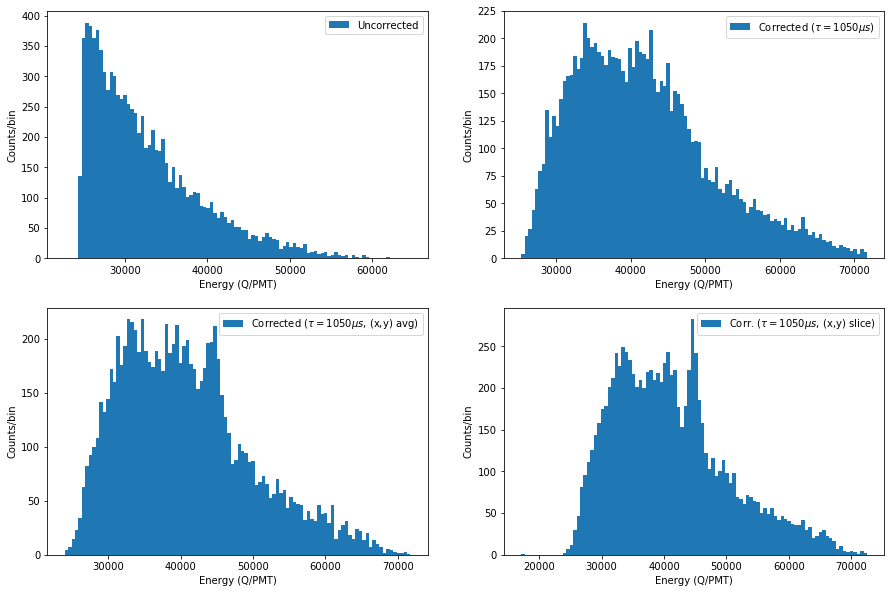

In [44]:
# energy spectrum
npmts = 11
ebins = 100
emin_hist = 150000; emax_hist = 800000
e_spec = []; emc_spec = []; r_spec = []; z_spec = []
ecorr_avg_spec = []; ecorr_tau_spec = []; ecorr_slice_spec = []
for ee in range(len(hitc_evt)):
    evt_E = sum([hh.E for hh in hitc_evt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[ee]])
    if(len(hitc_evt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(ee < len(hitc_mc)): evt_Emc = sum([hh.E for hh in hitc_mc[ee]])
    hr = np.array([np.sqrt(hh.X**2 + hh.Y**2) < 120. for hh in hitc_evt[ee]])
    #print("E = {0}, with tau = {1}, with xy = {2}, with slices = {3}".format(evt_E,evt_Ecorrtau,evt_Ecorrtau_xy,evt_Ecorrtau_xy_slice))
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 142.): #hr.all()):
        e_spec.append(evt_E)
        r_spec.append(evt_R)
        z_spec.append(evt_Z)
        ecorr_tau_spec.append(evt_Ecorrtau)
        ecorr_avg_spec.append(evt_Ecorrtau_xy)
        ecorr_slice_spec.append(evt_Ecorrtau_xy_slice)
    emc_spec.append(evt_Emc)

e_spec = np.array(e_spec)
ecorr_tau_spec = np.array(ecorr_tau_spec)
ecorr_avg_spec = np.array(ecorr_avg_spec)
ecorr_slice_spec = np.array(ecorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(e_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(ecorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, (x,y) avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, (x,y) slice)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

# Paolina analysis

In [ ]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([10,10,10],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm

In [ ]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    print("Track {0} with {1} hits...".format(nevt,len(hitc)))
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    evt_E = sum([hh.E for hh in hitc])
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    #print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)

In [ ]:
# Plot Eblob1 vs. Eblob2
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

#cuts_blob = ((dist_cuts) & (l_dblobs > trklen_low))
#((l_etotcorr > Ecut_low) & (l_etotcorr < Ecut_high) & 
#             (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs) & 
#             (l_dblobs > trklen_low))
#print(l_hcindex[np.nonzero(cuts_blob & (l_eblob1 > 500))])

# create the x-y projection
#hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_blob], l_eblob2[cuts_blob], normed=False, bins=(12, 12))
hxy, xxy, yxy = np.histogram2d(l_eblob1, l_eblob2, normed=False, bins=(25, 25))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob2 (Q)")
plt.ylabel("Eblob1 (Q)")
#plt.xlim([Ecut_low_blobs,max(l_eblob2[cuts_blob])])
#plt.ylim([Ecut_low_blobs,max(l_eblob1[cuts_blob])])
plt.colorbar()

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(e_spec[l_eblob1 < 20000],bins=30,label='Single-track')
plt.hist(e_spec[l_eblob1 > 20000],bins=40,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
nevt = 7
hitc = hitc_evt[nevt]
print("Running Paolina for event {0} (event number {1})".format(nevt,evtnum_hitc[nevt]))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)

vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2})".format(a.pos[0],a.pos[1],a.pos[2]))
print("Extreme1 at ({0},{1},{2})".format(b.pos[0],b.pos[1],b.pos[2]))

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(trk_energies,bins=200)
ax1.set_title("Paolina track energies")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_xlim([0,10000])
#ax2.set_yscale("log")

nn = 0
for ee,te in zip(evtnum_hitc,trk_energies):
    if(400 < te < 20000):
        print("Event {0} (number {1})".format(nn,ee))
    nn += 1

## Histograms from the Corona step

In [ ]:
# total charge
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# charge histogram
#ax1 = fig.add_subplot(121);
#plt.hist(l_qsipm,bins=200)
#ax1.set_title("Charge in all SiPMs in PMaps")
#ax1.set_xlabel("Charge (Q)")
#ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# charge vs. cluster energy
ax2 = fig.add_subplot(111);
plt.scatter(l_qsipm_ccenter,l_qsipm_qcluster,marker='.',s=0.5)
ax2.set_title("Central charge of cluster vs. total charge of cluster")
ax2.set_xlabel("Central charge (Q)")
ax2.set_ylabel("Cluster charge (Q)")
#ax1.set_yscale("log")

In [ ]:
# cluster charges
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
plt.hist(l_qsipm_cluster,bins=200)
ax1.set_title("Charge in all SiPMs in clusters")
ax1.set_xlabel("Charge (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
#hxy, xxy, yxy = np.histogram2d(l_etotcorr[dist_cuts], l_zavg[dist_cuts], normed=False, bins=(30, 30))
#extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
plt.hist(l_qsipm_ccenter,bins=200)
ax2.set_title("Central cluster charge")
ax2.set_xlabel("Charge (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

In [ ]:
# cluster charge vs. radial distance from local maxima
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
#plt.scatter(l_r_rlm,l_q_rlm,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rlm, l_r_rlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp1 = plt.colorbar(sp1)
ax1.set_title("SiPM charge vs. radius from initial local maximum")
ax1.set_xlabel("Radial distance (mm)")
ax1.set_ylabel("SiPM charge")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rnlm, l_r_rnlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp2 = plt.colorbar(sp2)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#plt.scatter(l_r_rnlm,l_q_rnlm,marker='.')
ax2.set_title("SiPM charge vs. radius from second local maximum")
ax2.set_xlabel("Radial distance (mm)")
ax2.set_ylabel("SiPM charge")

In [ ]:
# cluster charges
fig = plt.figure(4);
fig.set_figheight(15.0);
fig.set_figwidth(15.0);

# charge histograms for max clusters
for n in range(nccenters):
    splt_str = "32{0}".format(n+1)
    ax1 = fig.add_subplot(splt_str);
    plt.hist(l_qsipm_iccenter[n],bins=200)
    ax1.set_title("SiPM central charge for cluster {0}".format(n))
    ax1.set_xlabel("Charge (Q)")
    ax1.set_ylabel("Counts/bin")
    ax1.set_yscale("log")
    print("{0} entries for cluster {1}".format(len(l_qsipm_iccenter[n]),n))

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])